In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import rubin_sim.maf as maf
import rubin_sim.photUtils as photUtils
from rubin_sim.site_models import SeeingModel
import syseng_throughputs as st

In [2]:
defaultdirs = st.setDefaultDirs()
defaultdirs

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}

In [3]:
# Read dark sky and X=1 atmosphere (default is to use X=1.2 atmosphere otherwise)
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(st.findRootDir(), 'siteProperties', 'darksky.dat'))
atmosphere = st.readAtmosphere(defaultdirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

# READ WITHOUT ANY SYSTEM LOSSES
hardware, system = st.buildHardwareAndSystem(defaultdirs, atmosphereOverride=atmosphere, addLosses=False)

In [4]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
# Set up PhotometricParameters object - which stores readnoise, etc
readnoise = 8.8 # e-/read
darkcurrent = 0.2 # e-/s
photParameters_15 = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1, 
                                                     readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
photParameters_30 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1,
                                                   readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
# Make it easier to retrieve the appropriate version per-bandpass
photParams = {}
photParams['u'] = photParameters_30
for f in ('g', 'r', 'i', 'z', 'y'):
    photParams[f] = photParameters_15

    
# Fiducial seeing values 
# These fiducial seeing values correspond to a 500nm zenith atmospheric seeing contribution 
# equivalent to fwhm_500 = 0.62" (using our current seeing model) - see next cell
lsstDefaults = photUtils.LSSTdefaults()
fid_fwhmEff = {}
for f in filterlist:
    fid_fwhmEff[f] = lsstDefaults.FWHMeff(f)

In [5]:
m5_15 = st.makeM5(hardware, system, darksky=darksky, exptime=15, nexp=2, fwhm500=0.62, X=1)
m5_30 = st.makeM5(hardware, system, darksky=darksky, exptime=30, nexp=1, fwhm500=0.62, X=1)
pd.concat([pd.DataFrame(m5_30.loc['u']).T, m5_15['g': 'y']])

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.928137,0.814928,22.963465,102.706669,27.293040,0.046546,0.073870,0.501469,0.037956,23.586646,0.312964,0.180516,24.262094,489.215026,23.9,23.4
g,0.874696,0.771000,22.261440,504.857550,28.606826,0.156097,0.190207,0.214582,0.038840,24.572132,0.147798,0.076706,24.960955,861.925943,25.0,24.6
r,0.827759,0.732418,21.196382,995.429681,28.367612,0.125230,0.140620,0.125843,0.039067,24.568900,0.080333,0.039269,24.485075,1071.854774,24.7,24.3
i,0.796348,0.706598,20.477231,1434.180778,28.074607,0.095611,0.104467,0.096182,0.039173,24.462314,0.057098,0.026961,24.060917,1209.474927,24.0,23.6
z,0.774526,0.688661,19.599734,2177.554843,27.678090,0.066359,0.070688,0.068613,0.039297,24.298571,0.038346,0.017359,23.488593,1422.067354,23.3,22.9
y,0.757899,0.674993,18.610555,2889.771889,26.895188,0.032266,0.037720,0.169574,0.039370,23.866937,0.029175,0.012772,22.585932,1587.901620,22.1,21.7


In [6]:
darksky_mags = {}
for f in filterlist:
    darksky_mags[f] = darksky.calcMag(hardware[f])
print(darksky_mags)

{'u': 22.963465370574117, 'g': 22.261439550222065, 'r': 21.196382114661805, 'i': 20.47723146002019, 'z': 19.59973371705013, 'y': 18.610555426369544}


In [7]:
m5_15 = st.makeM5(hardware, system, sky_mags=darksky_mags, exptime=15, nexp=2, fwhm500=0.62, X=1)
m5_30 = st.makeM5(hardware, system, sky_mags=darksky_mags, exptime=30, nexp=1, fwhm500=0.62, X=1)
m5_dark = pd.concat([pd.DataFrame(m5_30.loc['u']).T, m5_15['g': 'y']])
m5_dark

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.928137,0.814928,22.963465,102.706669,27.293040,0.046546,0.073870,0.501469,0.037956,23.586646,0.312964,0.180516,24.262094,489.215026,23.9,23.4
g,0.874696,0.771000,22.261440,504.857550,28.606826,0.156097,0.190207,0.214582,0.038840,24.572132,0.147798,0.076706,24.960955,861.925943,25.0,24.6
r,0.827759,0.732418,21.196382,995.429681,28.367612,0.125230,0.140620,0.125843,0.039067,24.568900,0.080333,0.039269,24.485075,1071.854774,24.7,24.3
i,0.796348,0.706598,20.477231,1434.180778,28.074607,0.095611,0.104467,0.096182,0.039173,24.462314,0.057098,0.026961,24.060917,1209.474927,24.0,23.6
z,0.774526,0.688661,19.599734,2177.554843,27.678090,0.066359,0.070688,0.068613,0.039297,24.298571,0.038346,0.017359,23.488593,1422.067354,23.3,22.9
y,0.757899,0.674993,18.610555,2889.771889,26.895188,0.032266,0.037720,0.169574,0.039370,23.866937,0.029175,0.012772,22.585932,1587.901620,22.1,21.7


In [8]:
darkersky_mags = {}
brightersky_mags = {}
for f in filterlist:
    darkersky_mags[f] = darksky_mags[f] + 2.0
    brightersky_mags[f] = darksky_mags[f] - 2.0    
skybackground = {'brighter': brightersky_mags, 'dark': darksky_mags, 'darker': darkersky_mags}
m5 = {}
for sky in skybackground:
    m5_15 = st.makeM5(hardware, system, sky_mags=skybackground[sky], exptime=15, nexp=2, fwhm500=0.62, X=1)
    m5_30 = st.makeM5(hardware, system, sky_mags=skybackground[sky], exptime=30, nexp=1, fwhm500=0.62, X=1)
    m5[sky] = pd.concat([pd.DataFrame(m5_30.loc['u']).T, m5_15['g': 'y']])

In [9]:
for sky in skybackground:
    display(m5[sky])

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.928137,0.814928,20.963465,648.035270,27.293040,0.046546,0.073870,0.501469,0.038955,23.857825,0.064854,0.031402,23.533273,957.256083,23.9,23.4
g,0.874696,0.771000,20.261440,3185.435792,28.606826,0.156097,0.190207,0.214582,0.039478,24.704404,0.026570,0.011831,24.093226,1916.731669,25.0,24.6
r,0.827759,0.732418,19.196382,6280.736679,28.367612,0.125230,0.140620,0.125843,0.039602,24.643882,0.013661,0.005529,23.560058,2512.712822,24.7,24.3
i,0.796348,0.706598,18.477231,9049.068950,28.074607,0.095611,0.104467,0.096182,0.039654,24.517084,0.009525,0.003573,23.115687,2888.609827,24.0,23.6
z,0.774526,0.688661,17.599734,13739.442213,27.678090,0.066359,0.070688,0.068613,0.039710,24.336626,0.006297,0.002115,22.526648,3449.040175,23.3,22.9
y,0.757899,0.674993,16.610555,18233.227975,26.895188,0.032266,0.037720,0.169574,0.039742,23.896686,0.004754,0.001441,21.615681,3880.824722,22.1,21.7


,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.928137,0.814928,22.963465,102.706669,27.293040,0.046546,0.073870,0.501469,0.037956,23.586646,0.312964,0.180516,24.262094,489.215026,23.9,23.4
g,0.874696,0.771000,22.261440,504.857550,28.606826,0.156097,0.190207,0.214582,0.038840,24.572132,0.147798,0.076706,24.960955,861.925943,25.0,24.6
r,0.827759,0.732418,21.196382,995.429681,28.367612,0.125230,0.140620,0.125843,0.039067,24.568900,0.080333,0.039269,24.485075,1071.854774,24.7,24.3
i,0.796348,0.706598,20.477231,1434.180778,28.074607,0.095611,0.104467,0.096182,0.039173,24.462314,0.057098,0.026961,24.060917,1209.474927,24.0,23.6
z,0.774526,0.688661,19.599734,2177.554843,27.678090,0.066359,0.070688,0.068613,0.039297,24.298571,0.038346,0.017359,23.488593,1422.067354,23.3,22.9
y,0.757899,0.674993,18.610555,2889.771889,26.895188,0.032266,0.037720,0.169574,0.039370,23.866937,0.029175,0.012772,22.585932,1587.901620,22.1,21.7


,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.928137,0.814928,24.963465,16.277910,27.293040,0.046546,0.073870,0.501469,0.037234,22.915072,0.926690,0.656138,24.590520,361.517460,23.9,23.4
g,0.874696,0.771000,24.261440,80.014529,28.606826,0.156097,0.190207,0.214582,0.038090,24.113395,0.578806,0.364509,25.502217,523.558222,25.0,24.6
r,0.827759,0.732418,23.196382,157.764972,28.367612,0.125230,0.140620,0.125843,0.038242,24.257016,0.371345,0.215624,25.173192,568.708149,24.7,24.3
i,0.796348,0.706598,22.477231,227.302335,28.074607,0.095611,0.104467,0.096182,0.038342,24.217846,0.283490,0.157877,24.816450,603.092507,24.0,23.6
z,0.774526,0.688661,21.599734,345.119185,27.678090,0.066359,0.070688,0.068613,0.038504,24.118471,0.203362,0.108394,24.308493,668.282673,23.3,22.9
y,0.757899,0.674993,20.610555,457.997980,26.895188,0.032266,0.037720,0.169574,0.038615,23.722411,0.160320,0.083083,23.441405,722.161405,22.1,21.7


In [10]:
def m5_scale_withsky(
    expTime,
    nexp,
    airmass,
    FWHMeff,
    musky,
    darkSkyMag,
    Cm,
    dCm_infinity,
    kAtm,
    tauCloud=0,
    baseExpTime=15,
):
    """Return m5 (scaled) value for all filters.
    Parameters
    ----------
    expTime : float
        Exposure time (in seconds) for each exposure
    nexp : int
        Number of exposures
    airmass : float
        Airmass of the observation
    FWHMeff : np.ndarray or pd.DataFrame
        FWHM (in arcseconds) per filter
    musky : np.ndarray or pd.DataFrame
        Sky background (in magnitudes/sq arcsecond) per filter of the observation
    darkSkyMag : np.ndarray or pd.DataFrame
        Dark Sky, zenith magnitude/sq arcsecond - to scale musky. per filter
    Cm : np.ndarray or pd.DataFrame
        Cm value for the throughputs per filter
    dCm_infinity : np.ndarray or pd.DataFrame
        dCm_infinity values for the throughputs, per filter
    kAtm : np.ndarray or pd.DataFrame
        Atmospheric extinction values, per filter
    tauCloud : float, optional
        Extinction due to clouds
    baseExpTime : float, optional
        The exposure time used to calculate Cm / dCm_infinity. Used to scale expTime.
        This is the individual exposure exposure time.
    Returns
    -------
    np.ndarray or pd.DataFrame
        m5 values scaled for the visit conditions
    Note: The columns required as input for m5_scale can be calculated using
    the makeM5 function in lsst.syseng.throughputs.
    """
    # Calculate adjustment if readnoise is significant for exposure time
    # (see overview paper, equation 7)
    Tscale = expTime / baseExpTime * np.power(10.0, -0.4 * (musky - darkSkyMag))
    dCm = 0.0
    dCm += dCm_infinity
    dCm -= 1.25 * np.log10(1 + (10 ** (0.8 * dCm_infinity) - 1) / Tscale)
    # Calculate m5 for 1 exp - constants here come from definition of Cm/dCm_infinity
    m5 = (
        Cm
        + dCm
        + 0.50 * (musky - 21.0)
        + 2.5 * np.log10(0.7 / FWHMeff)
        + 1.25 * np.log10(expTime / 30.0)
        - kAtm * (airmass - 1.0)
        - 1.1 * tauCloud
    )
    if nexp > 1:
        m5 = 1.25 * np.log10(nexp * 10 ** (0.8 * m5))
    return m5, dCm

def m5_scale_simple(
    expTime,
    nexp,
    airmass,
    FWHMeff,
    musky,
    darkSkyMag,
    Cm,
    dCm_infinity,
    kAtm,
    tauCloud=0,
    baseExpTime=15,
):
    """Return m5 (scaled) value for all filters.
    Parameters
    ----------
    expTime : float
        Exposure time (in seconds) for each exposure
    nexp : int
        Number of exposures
    airmass : float
        Airmass of the observation
    FWHMeff : np.ndarray or pd.DataFrame
        FWHM (in arcseconds) per filter
    musky : np.ndarray or pd.DataFrame
        Sky background (in magnitudes/sq arcsecond) per filter of the observation
    darkSkyMag : np.ndarray or pd.DataFrame
        Dark Sky, zenith magnitude/sq arcsecond - to scale musky. per filter
    Cm : np.ndarray or pd.DataFrame
        Cm value for the throughputs per filter
    dCm_infinity : np.ndarray or pd.DataFrame
        dCm_infinity values for the throughputs, per filter
    kAtm : np.ndarray or pd.DataFrame
        Atmospheric extinction values, per filter
    tauCloud : float, optional
        Extinction due to clouds
    baseExpTime : float, optional
        The exposure time used to calculate Cm / dCm_infinity. Used to scale expTime.
        This is the individual exposure exposure time.
    Returns
    -------
    np.ndarray or pd.DataFrame
        m5 values scaled for the visit conditions
    Note: The columns required as input for m5_scale can be calculated using
    the makeM5 function in lsst.syseng.throughputs.
    """
    # Calculate adjustment if readnoise is significant for exposure time
    # (see overview paper, equation 7)
    Tscale = expTime / baseExpTime 
    dCm = 0.0
    dCm += dCm_infinity
    dCm -= 1.25 * np.log10(1 + (10 ** (0.8 * dCm_infinity) - 1) / Tscale)
    # Calculate m5 for 1 exp - constants here come from definition of Cm/dCm_infinity
    m5 = (
        Cm
        + dCm
        + 0.50 * (musky - 21.0)
        + 2.5 * np.log10(0.7 / FWHMeff)
        + 1.25 * np.log10(expTime / 30.0)
        - kAtm * (airmass - 1.0)
        - 1.1 * tauCloud
    )
    if nexp > 1:
        m5 = 1.25 * np.log10(nexp * 10 ** (0.8 * m5))
    return m5, dCm

In [16]:
# Zeljko's suggestion - calculate Cm in u band for a variety of exposure times and two values of sky
texp = np.concatenate((np.arange(1, 50, 1), np.arange(50, 100, 2), np.arange(100, 300, 10)))
Cm_u_dark = np.zeros(len(texp))
dCm_u_dark = np.zeros(len(texp))
m5_calc = np.zeros(len(texp))
m5_scale = np.zeros(len(texp))
Cm_u_darker = np.zeros(len(texp))
dCm_u_darker = np.zeros(len(texp))
m5_calc_darker = np.zeros(len(texp))
m5_scale_darker = np.zeros(len(texp))

for i, t in enumerate(texp):
    tmp = st.makeM5(hardware, system, sky_mags=skybackground['brighter'], exptime=t, nexp=1, fwhm500=0.62, X=1)
    Cm_u_dark[i] = tmp.loc['u']['Cm']
    m5_calc[i] = tmp.loc['u']['m5']
    tmp = st.makeM5(hardware, system, sky_mags=skybackground['dark'], exptime=t, nexp=1, fwhm500=0.62, X=1)
    Cm_u_darker[i] = tmp.loc['u']['Cm']
    m5_calc_darker[i] = tmp.loc['u']['m5']

m5_scale, dCm_u_dark = m5_scale_simple(texp, nexp=1, airmass=1, FWHMeff=0.7, 
                                       musky=skybackground['brighter']['u'], 
                                     darkSkyMag=skybackground['brighter']['u'], 
                                       Cm=m5['brighter'].loc['u']['Cm'],
                                        dCm_infinity=m5['brighter'].loc['u']['dCm_infinity'],
                                                 kAtm=m5['brighter'].loc['u']['kAtm'], baseExpTime=30)
m5_scale_darker, dCm_u_darker = m5_scale_simple(texp, nexp=1, airmass=1, FWHMeff=0.7, 
                                       musky=skybackground['dark']['u'], 
                                     darkSkyMag=skybackground['dark']['u'], 
                                       Cm=m5['dark'].loc['u']['Cm'],
                                        dCm_infinity=m5['dark'].loc['u']['dCm_infinity'],
                                                 kAtm=m5['dark'].loc['u']['kAtm'], baseExpTime=30)

In [17]:
idx = np.where(texp == 30)
print(texp[idx])

[30]


Text(0, 0.5, 'dCm')

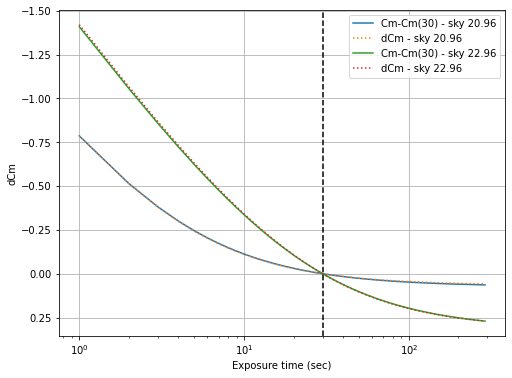

In [18]:
plt.figure(figsize=(8,6))
plt.plot(texp, Cm_u_dark - Cm_u_dark[idx], label=f"Cm-Cm(30) - sky {skybackground['brighter']['u']:.2f}")
plt.plot(texp, dCm_u_dark, linestyle=':', label=f"dCm - sky {skybackground['brighter']['u']:.2f}")
plt.plot(texp, Cm_u_darker - Cm_u_darker[idx], label=f"Cm-Cm(30) - sky {skybackground['dark']['u']:.2f}")
plt.plot(texp, dCm_u_darker, linestyle=':', label=f"dCm - sky {skybackground['dark']['u']:.2f}")
plt.axvline(30, color='k', linestyle='--')
plt.grid()
plt.legend()
plt.xscale('log')
ylims = plt.ylim()
plt.ylim(ylims[1], ylims[0])
plt.xlabel('Exposure time (sec)')
plt.ylabel("dCm")

In [19]:
# so -- we can't see the effect of scaling with the sky unless we actually have some m5 values both above and below
# the sky background readnoise limit ... and looking at how we scale tau with sky, it has to be a different sky
# value than the actual value of the darksky. 
# So now -- don't vary exposure time, but do vary sky background, and look at g band 
# Also note -- the problem came up when using a KNOWN Cm to calculate *m5* in a sky condition 
# that was different than how the Cm was calculated. So now we calculate Cm ONCE, and then use this to scale to
# different conditions .. and compare with "from scratch" m5 calculation

skyrange = np.arange(18, 23, .1)
tmpsky = skybackground['brighter'].copy()

ref = st.makeM5(hardware, system, sky_mags=skybackground['dark'], exptime=30, nexp=1, fwhm500=0.62, X=1)
Cm_ref = ref.loc['g']['Cm']
dCm_inf = ref.loc['g']['dCm_infinity']
darkskyMag = skybackground['dark']['g']
kAtm = ref.loc['g']['kAtm']
seeing_model = SeeingModel()
fwhmeff = seeing_model(0.62, 1)['fwhmEff']
fwhmeff_g = fwhmeff[1]

m5_calc_sky = np.zeros(len(skyrange))
m5_scale_tau = np.zeros(len(skyrange))
m5_scale_sky = np.zeros(len(skyrange))

for i, sky in enumerate(skyrange):
    tmpsky['g'] = sky
    tmp = st.makeM5(hardware, system, sky_mags=tmpsky, exptime=30, nexp=1, fwhm500=0.62, X=1)
    m5_calc_sky[i] = tmp.loc['g']['m5']
    m5_scale_tau[i], jj = m5_scale_simple(30, nexp=1, airmass=1, FWHMeff=fwhmeff_g, musky=sky, 
                                         darkSkyMag=darkskyMag, Cm=Cm_ref,
                                         dCm_infinity=dCm_inf,
                                         kAtm=kAtm, baseExpTime=30)
    m5_scale_sky[i], jj = m5_scale_withsky(30, nexp=1, airmass=1, FWHMeff=fwhmeff_g, musky=sky, 
                                         darkSkyMag=darkskyMag, Cm=Cm_ref,
                                         dCm_infinity=dCm_inf,
                                         kAtm=kAtm, baseExpTime=30)

Text(0, 0.5, 'm5')

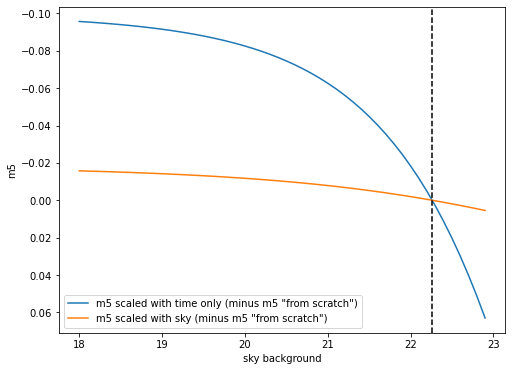

In [26]:
plt.figure(figsize=(8,6))
#plt.plot(skyrange, m5_calc_sky, label='calculated m5')
plt.plot(skyrange, m5_scale_tau - m5_calc_sky, label='m5 scaled with time only (minus m5 "from scratch")')
plt.plot(skyrange, m5_scale_sky - m5_calc_sky, label='m5 scaled with sky (minus m5 "from scratch")')
plt.axvline(darkskyMag, color='k', linestyle='--')
plt.legend()
#plt.xscale('log')
ylims = plt.ylim()
plt.ylim(ylims[1], ylims[0])
plt.xlabel('sky background')
plt.ylabel("m5")